<a href="https://colab.research.google.com/github/luisfranc123/Tutorials_Statistics_Numerical_Analysis/blob/main/Applied_Statistics/Linear_Model_Selection_Regularization_Ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Linear Model Selection and Regularization (Chapter 6)**

---




###**6.5 Lab: Linear Models and Regularization**

In this lab we implement many of the techniques discussed in this chapter. We first import some of th libaries needed.

In [ ]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 11.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=8c91d09579a2cb78e0f4b37aa9ac70924116cf034210186c97f3b43e6115a3e5
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

In [ ]:
#!pip install numpy==1.26.6 --force-reinstall
!pip install l0bnb --upgrade
from l0bnb import fit_path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-none-any.whl size=22296 sha256=2b725424bf74d0a4c4e10988df08ca0efaea36da26103388d453e5fd9e790ccc
  Stored in directory: /root/.cache/pip/wheels/0e/74/8b/8a39b657554150b98e1520971211118b5137e6a1873a85f66a
Successfully built l0bnb


####**6.5.1 Subset Selection Methods**

Here we implement methods that reduce the number of parameters in a model by restricting the model to a subset of the input variables.

#####***Forward Selection***

We will apply the forward-selction approach to the `Hitters` data. We wish to predict a beseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

First of all, we note that the `Salary` variable is missing for some of the players. The `np.isnan()` function can be used to identify the missing observations. It returns an array of the same shape as the input vector, with a `True` for any elements that are missing, and `False` for non-missing elements. The `sum()` method can then be used to count all of the missing elements.



In [ ]:
Hitters = load_data('Hitters')
print(np.isnan(Hitters['Salary']).sum())

59


In [ ]:
print(Hitters.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AtBat      322 non-null    int64   
 1   Hits       322 non-null    int64   
 2   HmRun      322 non-null    int64   
 3   Runs       322 non-null    int64   
 4   RBI        322 non-null    int64   
 5   Walks      322 non-null    int64   
 6   Years      322 non-null    int64   
 7   CAtBat     322 non-null    int64   
 8   CHits      322 non-null    int64   
 9   CHmRun     322 non-null    int64   
 10  CRuns      322 non-null    int64   
 11  CRBI       322 non-null    int64   
 12  CWalks     322 non-null    int64   
 13  League     322 non-null    category
 14  Division   322 non-null    category
 15  PutOuts    322 non-null    int64   
 16  Assists    322 non-null    int64   
 17  Errors     322 non-null    int64   
 18  Salary     263 non-null    float64 
 19  NewLeague  322 non-null    ca

We see that `Salary` is missing for 59 players. The `dropna()` method of data frames remove all of the rows that have missing values in any variable.

In [ ]:
Hitters = Hitters.dropna()
print(Hitters.shape)

(263, 20)


We first choose the best model using forward selection based on $C_p = \frac{1}{n}(RSS + 2d\hat\sigma^2)$, where $\hat\sigma^2$ is the estimate of the variance of the error $\epsilon^*$ associated with each response measurement ($Y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p + \epsilon^*$). This score is not built-in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use it as a scorer. By default, `sklearn` tries to maximize a score, hence our scoring function computes the negative $C_p$ statistic.

In [ ]:
def nCp(sigma2, estimator, X, Y):
  """
  Negative Cp statistic
  """
  n, p = X.shape
  Y_hat = estimator.predict(X)
  RSS = np.sum((Y - Y_hat)**2)

  return -(RSS + 2*p*sigma2)/n

We need to estimate the residual variance $\sigma^2$, which is the first argument in our scoring function above. We will fit the biggest model, using all the variables, and estimate $\sigma^2$ based on its MSE.

In [ ]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale

In [ ]:
print(sigma2)

99591.35617968219


The function `sklearn_selected()` expects a scorer with just three arguments — the last three in the definition of `nCp()` above. We use the function `partial()` to freeze the first argument with our estimate of $\sigma^2$.

In [ ]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done trough the object `Stepwise()` in the `ISLP.models` package. The method `Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()` runs a fixed number of steps of stepwise search.

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = len(design.terms))

We now fit a linear regression with `Salary` as outcome using forward selection. To do so, we use the function `sklearn_selected()` from the `ISLP.models` package. This takes a model from `statsmodels` along with a search strategy and selects a model with its `fit` method. Without specifiying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be selected.

In [ ]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selcted.

In [ ]:
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring = neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#####***Choosing Among Models Using the Validation Set Approach and Cross-Validation***

As an alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models` computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use the defaults here, which selects the model at each step based on the biggest reduction in RSS.

In [ ]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction = 'forward')
full_path = sklearn_selection_path(OLS, strategy)

We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [ ]:
print(Hitters.shape)

(263, 20)


In [ ]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
print(Yhat_in.shape)

(263, 20)


In [ ]:
print(Yhat_in)

[[ 535.92588213  602.03516506  505.03086087 ...  372.19029353
   361.43503052  362.13606585]
 [ 535.92588213  484.97403646  564.66713304 ...  706.17406201
   712.13809677  712.6952059 ]
 [ 535.92588213  937.39947944  995.59888206 ... 1166.41289971
  1171.29048328 1171.31111145]
 ...
 [ 535.92588213  348.13906857  432.11115796 ...  247.09365751
   245.71268797  243.69097639]
 [ 535.92588213  606.78088649  717.12346513 ... 1026.13008776
  1023.92340166 1023.30029814]
 [ 535.92588213  556.95081148  759.48176151 ...  708.6674326
   703.9112215   705.7780666 ]]


This gives us an array of fittd values — 20 steps in all, including the fitted mean for the null model — which we can use to evaluate in-sample MSE. As expected, the in-sample MSE improves each step we take, indicating we must use either the validation or cross-validation approach to select the number of steps. We fix the y-axis to range from 50,000 to 250,000 to compare the cross-validation and validation set MSE below, as well as other methods such as ridge regression, lasso and principal components regression.

In [ ]:
((Yhat_in - Y[:, None])**2).mean(0)

array([202734.26915835, 137565.32036138, 116526.84368963, 111214.05648619,
       106353.04872934, 103231.55677571,  99600.39516196,  98685.23605214,
        95662.48612198,  94350.00527219,  93157.42029559,  92727.54772411,
        92521.79611891,  92354.17428989,  92200.22963039,  92148.96332784,
        92088.88772977,  92051.12835224,  92022.19527998,  92017.86901773])

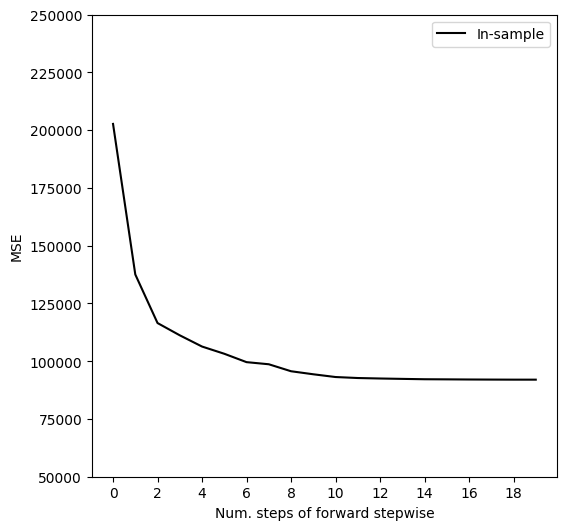

In [ ]:
mse_fig, ax = subplots(figsize = (6, 6))
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps), insample_mse, 'k', label = 'In-sample')
ax.set_ylabel('MSE', fontsize = 10)
ax.set_xlabel('Num. steps of forward stepwise', fontsize = 10)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000]);

Notice the expression `None` in `Y[:, None]` above. This adds an axis (dimension) to the one-dimensional array `Y`, which allows it to be recycled when subtracted from the two-dimensional `Yhat_in`.

We are now ready to use cross-validation to estimate test error along the model path. We must use *only the training observations* to perform all aspects of model-fitting — including variable selection. Therefore, the determination of which model of a given size is best must be made using *only the training observations* in each training fold. This point is subtle but important. If the full data set is used to select the best subset at each step, then the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

We now compute the cross-validated predicted values using a 5-fold cross-validation.

In [ ]:
K = 5
kfold = skm.KFold(K, random_state = 0, shuffle = True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv = kfold)
print(Yhat_cv.shape)

(263, 20)


The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on training fold that did not include that row.

At each model along the path, we compute the MSE in each of the cross-validation folds. These we will average to the get the mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean. Hence we must know the test indices for each cross-validation split. This can be found by using the `split()` method of `kfold`. Because we fixed the random state above, whenever we split any array with the same number of rows as $Y$ we recover the same triaing and test indices, thugh we simply ignore the training indices below.

In [ ]:
cv_mse = []
for train_idx, test_idx  in kfold.split(Y):
  errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
  cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
print(cv_mse.shape)

(20, 5)


In [ ]:
print(cv_mse[:5])

[[297431.06375465 213373.26684906 164217.86614576 173485.72836052
  172188.60953974]
 [179409.9479167  171503.22142442 119051.86818073 116989.19290773
  140209.85934929]
 [169081.87136598 149740.51439506 106610.80755336 102201.60230676
  140916.43073648]
 [161065.23003134 158039.08094899 109849.16390754 109662.66982833
  148364.79459334]
 [143343.94710477 136954.50569394  97833.92005879 101684.74147948
  145424.24181961]]


We now add the cross-validation error estimates to our MSE plot. We iclude the mean error across the five folds, and the estimate of the standard error of the mean.

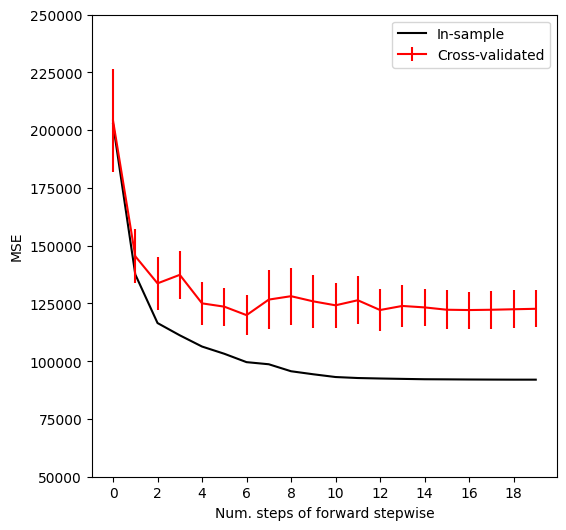

In [ ]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1),
            cv_mse.std(1)/np.sqrt(K),
            label = 'Cross-validated',
            c = 'r') # Color red
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

To repeat the above using the validation set approach, we simply change our `cv` argument to a validation set; one random split of the data into a test and training. We choose a test size of 20%, similar to the size of each test set in 5-fold cross-validation.

In [ ]:
validation = skm.ShuffleSplit(n_splits = 1,
                              test_size = 0.2,
                              random_state = 0)
for train_idx, test_idx in validation.split(Y):
  full_path.fit(Hitters.iloc[train_idx],
                Y[train_idx])
  Yhat_val = full_path.predict(Hitters.iloc[test_idx])
  errors = (Yhat_val - Y[test_idx, None])**2
  validation_mse = errors.mean(0)

Asfor the in-sample MSE case, the validation set approach does not provide standard errors.

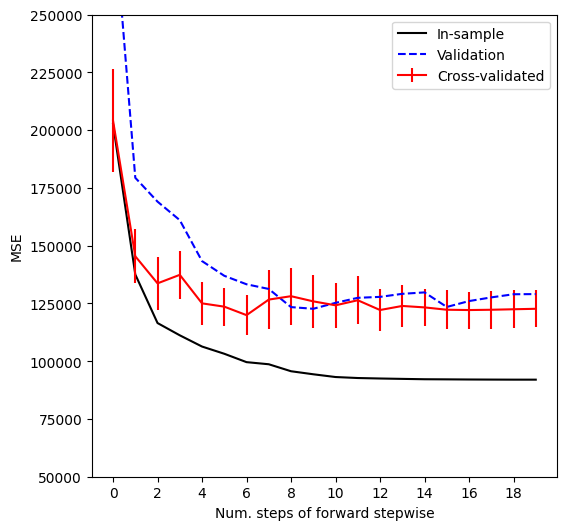

In [ ]:
ax.plot(np.arange(n_steps), validation_mse, 'b--', label = 'Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

#####***Best Subset Selection***

Forward stepwise is a *greedy* selection procedure; at each step it augments the current set by including oe additional variable. We now apply best subset selection to the `Hitters` data, which for every subset size, searches for the best set of predictors.

We will use a package called `10bnb` to perform best subset selection. Instead of constraining the subset to be a given size, this package produces a path of solutions using the subset size as a penalty rather than a constraint. ALthough the distinction is subtle, the difference comes when we cross-validate.  

In [ ]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis = 1)
X = np.asarray(D)

In [ ]:
print(X)

[[315.  81.   7. ...  43.  10.   1.]
 [479. 130.  18. ...  82.  14.   0.]
 [496. 141.  20. ...  11.   3.   1.]
 ...
 [475. 126.   3. ... 113.   7.   0.]
 [573. 144.   9. ... 131.  12.   0.]
 [631. 170.   9. ...   4.   3.   0.]]


Here we excluded the first column corresponding to the intercept, as `10bnb` will fit the intercept separately. We can find a path using the `fit_path()` function.

In [ ]:
#%pip install numpy --upgrade

In [ ]:
#path = fit_path(X, Y, max_nonzeros = X.shape[1])

####**6.5.2 Ridge Regression and the Lasso**

We will use the `sklearn.linear_model` package (for which we use `skl` as shorthand below) to fit ridge and lasso regularized linear models on the `Hitters` data. We start with the model matrix `X` (without an intercept) that we computed in the previus section on best subset regression.

#####***Ridge Regression***

We will use the function `skl.ElasticNet()` to fit both ridge and the lasso. To fit a *path* of ridge regression models, we use `skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture; ridge regression corresponds to `l1_ratio = 0`- It is good practice to standardize the columns of `X` in these applications, if the variables are measured in different units. Since `skl.ElasticNet()` does no normalization, we have to take care of that ourselves. Since we standardize first, in order to find the coefficient estimates on the original scale, we must *unstandardize* the coefficient estimates. The parameter $\lambda$ in $RSS + \lambda\sum_{j=1}^p{\beta_j^2}$ and $RSS + \lambda\sum_{j=1}^p{|\beta_j|}$, where $RSS = \sum_{i = 1}^{n}{(y_i-\beta_0-\sum_{j = 1}^{p}{\beta_jx_{ij}})}$, is called `alphas` in `sklearn`.

In [ ]:
print(X[None, :])
print("-"*50)
print(X.mean(0)[None, :])

[[[315.  81.   7. ...  43.  10.   1.]
  [479. 130.  18. ...  82.  14.   0.]
  [496. 141.  20. ...  11.   3.   1.]
  ...
  [475. 126.   3. ... 113.   7.   0.]
  [573. 144.   9. ... 131.  12.   0.]
  [631. 170.   9. ...   4.   3.   0.]]]
--------------------------------------------------
[[4.03642586e+02 1.07828897e+02 1.16197719e+01 5.47452471e+01
  5.14866920e+01 4.11140684e+01 7.31178707e+00 2.65754373e+03
  7.22186312e+02 6.92395437e+01 3.61220532e+02 3.30418251e+02
  2.60266160e+02 4.71482890e-01 5.09505703e-01 2.90711027e+02
  1.18760456e+02 8.59315589e+00 4.63878327e-01]]


In [ ]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
print(soln_array.shape)

(19, 100)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did n

Here we extract the array of coefficients correpsonding to the solutions along the regularization path. By default the `skl.ElasticNet.path` method fits a path along an automatically selected range of $\lambda$ values, except for the case when `l1_ratio = 0`, which results in ridge regression (as is the case here). So here we have chosen to implement the function over a grid of values ranging from $\lambda = 10^8$ to $\lambda = 10^{-2}$ scaled by the standard deviation of $y$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit.

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, that can be accessed by a column of `soln_array`. In this case, `soln_array` is a $19 * 100$ matrix with 19 rows (one for each predictor) and 100 columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [ ]:
soln_path = pd.DataFrame(soln_array.T,
                         columns = D.columns,
                         index = -np.log(lambdas))
soln_path.index_name = "negative log(lambda)"
print(soln_path.sample(5))

                AtBat        Hits      HmRun       Runs        RBI  \
-3.937818    3.041143    3.430883   2.603255   3.262581   3.464023   
 8.621737 -290.257600  335.066817  36.215270 -58.040799 -25.488830   
-9.054674    0.020752    0.023062   0.018030   0.022072   0.023626   
-8.356921    0.041660    0.046302   0.036193   0.044312   0.047431   
-0.216469   15.676622   32.046728   9.170493  25.023553  22.353826   

                Walks      Years      CAtBat      CHits     CHmRun  \
-3.937818    3.465733   3.022324    4.022436   4.219763   4.027658   
 8.621737  134.399199 -18.348451 -380.430407  94.942058  -8.404442   
-9.054674    0.023334   0.021058    0.027656   0.028854   0.027593   
-8.356921    0.046849   0.042270    0.055517   0.057924   0.055392   
-0.216469   30.610876  11.237793   25.378896  32.220852  29.340709   

                CRuns        CRBI      CWalks  League[N]  Division[W]  \
-3.937818    4.325676    4.359484    3.727808  -0.041261    -1.612095   
 8.621737  4

We plot th paths to get a sense of how the coeffieicnts vary with $\lambda$. To control the location of the legend we first set `legend` to `false` in the plot method, adding it afterward with the `legend()` method of `ax`.

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2852988967.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


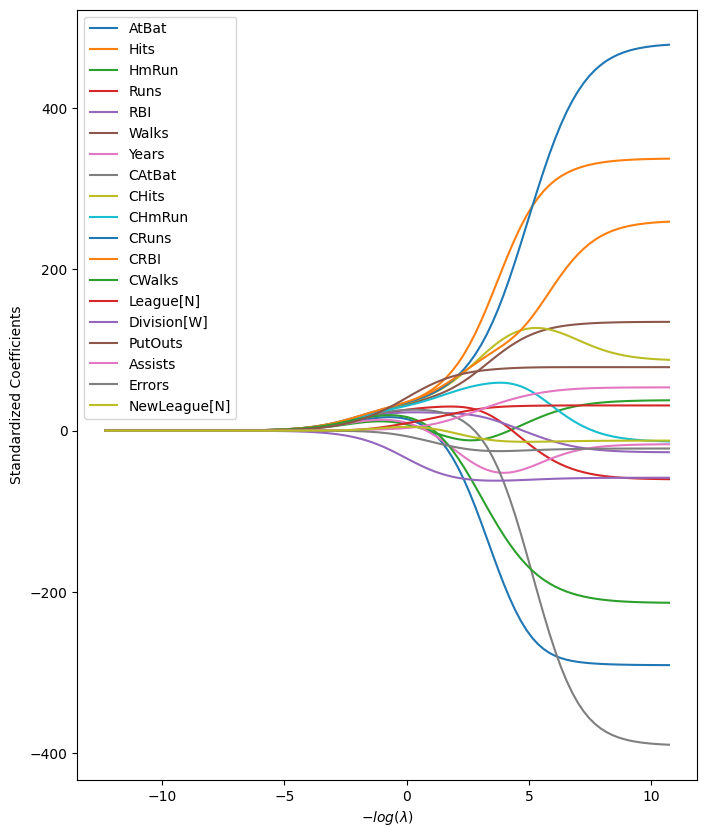

In [ ]:
path_fig, ax = subplots(figsize = (8, 10))
soln_path.plot(ax = ax, legend = False)
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Standardized Coefficients', fontsize = 10)
ax.legend(loc = 'upper left');

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm, when a large value of λ is used, as compared to when a small value of λ is used. (Recall that the $l_2$ norm is the square root of the sum of squared coefficient values.) We display the coefficients at the 40th step, where λ is 25.535.

In [ ]:
beta_hat = soln_path.loc[soln_path.index[39]]
print(f"lambda_{39} = {lambdas[39]} \n{beta_hat}")

lambda_39 = 25.53538897200662 
AtBat           5.433750
Hits            6.223582
HmRun           4.585498
Runs            5.880855
RBI             6.195921
Walks           6.277975
Years           5.299767
CAtBat          7.147501
CHits           7.539495
CHmRun          7.182344
CRuns           7.728649
CRBI            7.790702
CWalks          6.592901
League[N]       0.042445
Division[W]    -3.107159
PutOuts         4.605263
Assists         0.378371
Errors         -0.135196
NewLeague[N]    0.150323
Name: -3.240065292879872, dtype: float64


Let's compute the $l_2$ norm of the standardized coefficients.

In [ ]:
print(f"l2 Norm: {np.linalg.norm(beta_hat):.4f}")

l2 Norm: 24.1706


In contrast, here is the $l_2$ norm when $\lambda = 2.44e-01$. Note the much larger $l_2$ norm of the coeffieicnts associated with this smaller value of $\lambda$.

In [ ]:
beta_hat = soln_path.loc[soln_path.index[59]]
print(f"lambda_{39} = {lambdas[59]:.4f} \nl2 Norm: {np.linalg.norm(beta_hat):.4f}")

lambda_39 = 0.2437 
l2 Norm: 160.4237


Above we normalized `X` upfront, and fit the ridge model using `Xs`. The `Pipeline()` object in `sklearn` provides a clear way to separate feature normalization from the fitting of the ridge model itself.

In [ ]:
ridge = skl.ElasticNet(alpha = lambdas[59], l1_ratio = 0)
scaler = StandardScaler(with_mean = True, with_std = True)
pipe = Pipeline(steps = [('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=np.float64(0.24374766133488554),
                            l1_ratio=0))])

We show that it gives the same $l_2$ norm as in the previous fit on the standardized data.

In [ ]:
print(np.linalg.norm(ridge.coef_))

160.42371017725904


Notice that tje operation `pipe.fit(X, Y)` above has changed the `ridge`object, and in particular has added attributes such as `coef_` that were no there before.

#####***Estimating Test Error of Ridge Regression***

Choosing an *a priori* value of $\lambda$ for ridge regression is difficult if not impossible. We will want to use the validation method or cross-validation to select the tunning parameter. The `Pipeline()` approach can be used in `skm.cross_validate()` with either a validation method (i.e. `validation`) or $k-$fold cross-validation.

We fix the random state of the splitter so that the results obtained will be reproductible.

In [ ]:
validation = skm.ShuffleSplit(n_splits = 1,
                              test_size = .5,
                              random_state = 0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring = 'neg_mean_squared_error',
                             cv = validation)
-results['test_score']

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

The test MSE is $1.342e{+}05$. Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. We can get the same result by fitting a ridge regression model with a *very* large value of $\lambda$.

In [ ]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring = 'neg_mean_squared_error',
                             cv = validation)
-results['test_score']

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

Obviously choosing $\lambda = 0.01$ is arbitrary, so we will use cross-validation or the validation-set approach to choose the tunning parameter $\lambda$. The object `GridSearchCV()` allows exhaustive grid search to choose such a parameter.

We first use the validation set method to choose $\lambda$.

In [ ]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std() # Define the set of lambdas
param_grid = {'ridge__alpha': lambdas} # Searching Grid
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv = validation,
                        scoring = 'neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=np.float64(0.005899006046740856),
                            l1_ratio=0))])

Alternatively, we can use 5-fold cross-validation.

In [ ]:
K = 5
kfold = skm.KFold(K, random_state = 0, shuffle = True)
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv = validation,
                        scoring = 'neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=np.float64(0.005899006046740856),
                            l1_ratio=0))])

We now plot the cross-validated MSE as a function of $-log(\lambda)$, which has shrinkage decreasing from left to right.

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-955272791.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('-log$(\lambda)$', fontsize = 10)


Text(0, 0.5, 'Cross-Validated MSE')

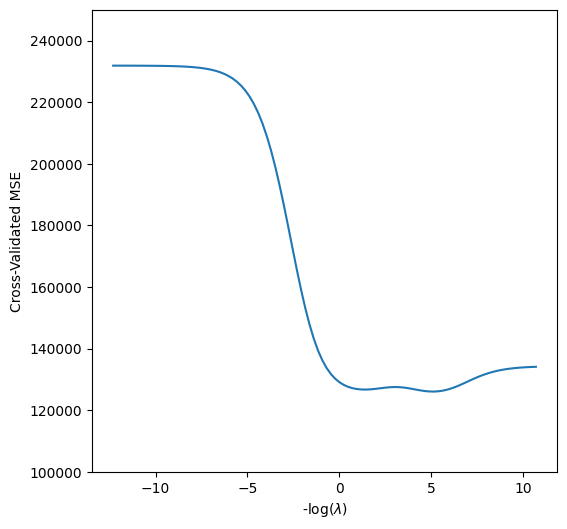

In [ ]:
ridge_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr = grid.cv_results_['std_test_score']/np.sqrt(K))

ax.set_ylim([100000, 250000])
ax.set_xlabel('-log$(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)

One can cross-validate different metrics to choose a parameter. The default metric for `skl.ElasticNet()` is test $R^2$. Let's compare $R^2$ to MSE for cross-validation here.

In [ ]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv = kfold)
grid_r2.fit(X, Y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

FInally, let's plot the rsults for cross-validated $R^2$.

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3113157967.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


Text(0, 0.5, 'Cross-Validated $R^2$')

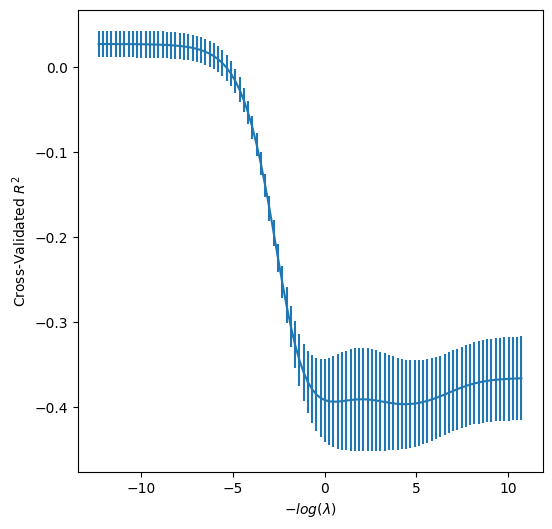

In [ ]:
ridge_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(lambdas),
            -grid_r2.cv_results_['mean_test_score'],
            yerr = grid_r2.cv_results_['std_test_score']/np.sqrt(K))
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated $R^2$', fontsize = 10)

#####***Fast Cross-Validation for Solution Paths***

The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, crating what is known as a *solution path* or *regularization path*. Hence there is a sepcialized code to fit such paths, and to choose a suitable value of $\lambda$ using cross-validation. Even with identical splits the results will not agree *exactly* with our `grid` above because the standardization of each feature in `grid` is carried out on each fold, while in `pipeCV` below it is carried out only once. Nevertheless, the results are similar as the normalization is relatively stable across folds.

In [ ]:
ridgeCV = skl.ElasticNetCV(alphas = lambdas,
                           l1_ratio = 0,
                           cv = kfold)
pipeCV = Pipeline(steps= [('scaler', scaler),
                          ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.355502333, tolerance: 3759.109166869193
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Let's produce a plot again of the cross-validation error to see that it is similar to using `skm.GridSearchCV`.  

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2202414443.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


Text(0, 0.5, 'Cross-Validated MSE')

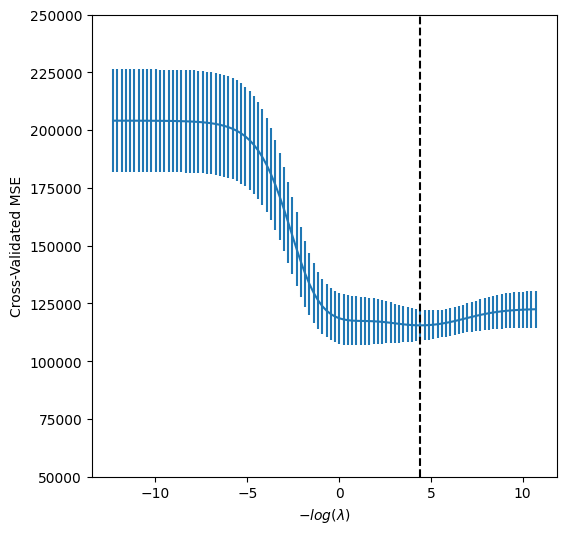

In [ ]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr = tuned_ridge.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c = 'k', ls = '--')
ax.set_ylim([50000, 250000])
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)

In [ ]:
print(f"Min Lambda: {tuned_ridge.alpha_:.4e}")

Min Lambda: 1.1852e-02


We see that the value of $\lambda$ that results in the smallest cross-validation error is 1.19e-02, available as the value `tuned_ridge.alpha_`. What is test MSE associated with this value of $\lambda$?

In [ ]:
print(f"MSE associated to Lambda = ({tuned_ridge.alpha_:.4e})")
print(f"{np.min(tuned_ridge.mse_path_.mean(1)):.4f}")

MSE associated to Lambda = (1.1852e-02)
115526.7063


This represents a further improvement over the test MSE that we got using $\lambda = 4$. Finally, `tuned_ridge.coef_` has the coefficients fit on the entire data set at this value of $\lambda$.

In [ ]:
print(tuned_ridge.coef_)

[-222.80877051  238.77246614    3.21103754   -2.93050845    3.64888723
  108.90953869  -50.81896152 -105.15731984  122.00714801   57.1859509
  210.35170348  118.05683748 -150.21959435   30.36634231  -61.62459095
   77.73832472   40.07350744  -25.02151514  -13.68429544]


**As expected, none of the coefficients are zero—ridge regression does not perform variable selection!**


#####***Evaluating Test Error of Cross-Validation Ridge***

Choosing $\lambda$ using cross-validation provides a single regression estimator, similar to fitting a linear regression model as we saw in Chapter 3. It is threfore reasonable to estimate what its test error is. We run into a problem here in that cross-validation will have *touched* all of its data in choosing $\lambda$, hence we have no further data to estimate test error. A compromise is to do an initial split of the data into two disjoint sets: a trining set and a test set. We then fit a cross-validation tuned ridge regression on the training set, and evaluate its performance on the test set. We mooght call this cross-validation nested within the validation set approach. A priori there is no reason to use half of the data for each of the two sets in validation. Below, we use 75% for training and 25% for test, with the estimator being ridg regression tuned using 5-fold cross validation. This can be achieved i code as follows:

In [ ]:
outer_valid = skm.ShuffleSplit(n_splits = 1,
                               test_size = 0.25,
                               random_state = 1)
inner_cv = skm.KFold(n_splits = 5,
                     shuffle = True,
                     random_state = 2)
ridgeCV = skl.ElasticNetCV(alphas = lambdas,
                           l1_ratio = 0,
                           cv = inner_cv)
pipeCV = Pipeline(steps = [('scaler', scaler),
                           ('ridge', ridgeCV)])

In [ ]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv = outer_valid,
                             scoring = 'neg_mean_squared_error')
print(-results['test_score']);

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.89304734, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did

[132393.84003227]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5019549.576235702, tolerance: 3224.8236814135257
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4968593.444998876, tolerance: 3224.8236814135257
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinat

#####***The Lasso***

We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we once again use the `ElasticNetCV()` function; however, this time we use the argument `l1_ratio = 1`. Other than that, we proceed just as we did in fitting a ridge model.

In [ ]:
lassoCV = skl.ElasticNetCV(n_alphas = 100,
                          l1_ratio = 1,
                          cv = kfold)
pipeCV = Pipeline(steps = [('scaler', scaler),
                           ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tunned_lasso = pipeCV.named_steps['lasso']
print(f"{tunned_lasso.alpha_:.4f}")

3.1472


In [ ]:
lambdas, soln_array = skl.lasso_path(Xs,
                                     Y,
                                     n_alphas = 100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns = D.columns,
                         index = -np.log(lambdas))
print(soln_path)

                AtBat        Hits      HmRun       Runs        RBI  \
-5.542369    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.472594    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.402819    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.333043    0.000000    0.000000   0.000000   0.000000   0.000000   
-5.263268    0.000000    0.000000   0.000000   0.000000   0.000000   
...               ...         ...        ...        ...        ...   
 1.086285 -292.618320  330.147359  25.671504 -49.562410 -13.598973   
 1.156060 -292.511837  330.496934  26.317012 -50.124459 -14.357879   
 1.225835 -292.413043  330.823484  26.918970 -50.648775 -15.065567   
 1.295611 -292.320279  331.127368  27.480414 -51.137572 -15.725645   
 1.365386 -292.233620  331.410616  28.004031 -51.593383 -16.341255   

                Walks      Years      CAtBat      CHits  CHmRun       CRuns  \
-5.542369    0.000000   0.000000    0.000000   0.000000     0.0    0.000000   
-

We can see from the coefficient plot of the standardized coefficients that depending on the choice of tunning parameter, some of the coefficients will be exactly equal to zero.

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2975322563.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


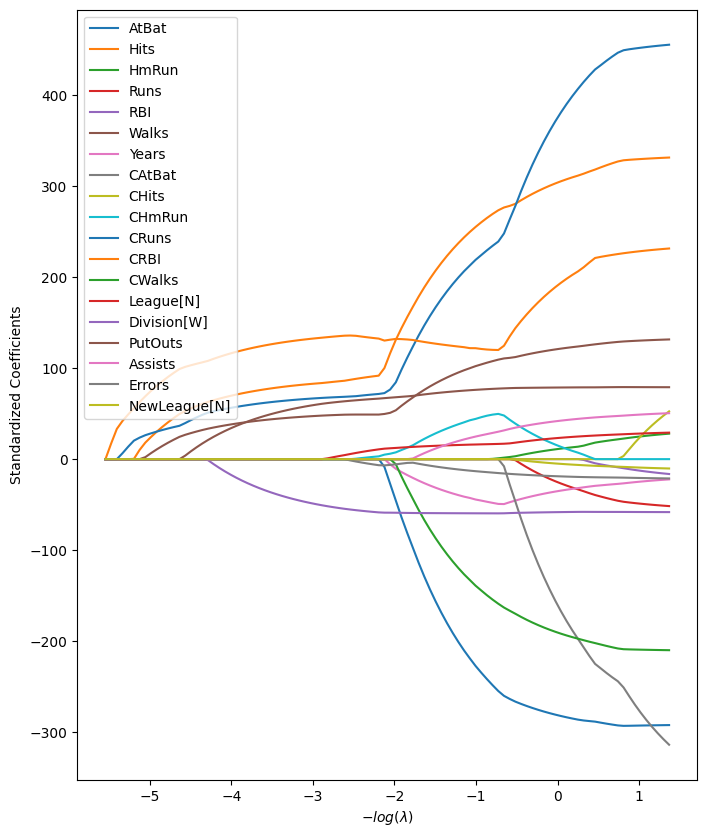

In [ ]:
path_fig, ax = subplots(figsize = (8, 10))
soln_path.plot(ax = ax, legend = False)
ax.legend(loc = 'upper left')
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Standardized Coefficients', fontsize = 10);

Tje smallest cross-validated error is lower thnt the test set MSE of the null model and of least squares, and very similar to the test MSE of $115526.71$ of ridge regression with $\lambda$ chosen by cross-validation.

In [ ]:
print(f"{np.min(tunned_lasso.mse_path_.mean(1)):.4f}")

114690.7312


Let's again produce a plot of the cross-validation error.

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1480700416.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


Text(0, 0.5, 'Cross-Validated MSE')

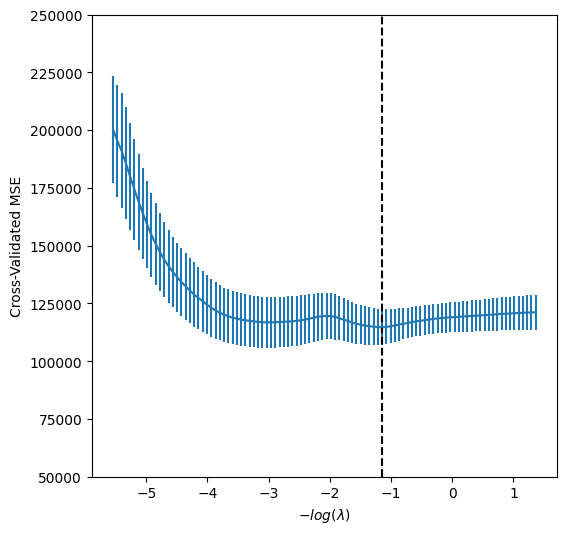

In [ ]:
#tuned_ridge = pipeCV.named_steps['ridge']
lassoCV_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(tunned_lasso.alphas_),
            tunned_lasso.mse_path_.mean(1),
            yerr = tunned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(tunned_lasso.alpha_), c = 'k', ls = '--')
ax.set_ylim([50000, 250000])
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)

**However, the lasso has a substaintial advantage over the ridge regression in that the resulting coefficient estimates are sparse. Here we see that 6 of the 19 coefficient estimates are exactly zero. So the lasso model with $\lambda$ chosen by cross-validation contains only 13 variables**.

In [ ]:
print(tunned_lasso.coef_)

[-210.01008773  243.4550306     0.            0.            0.
   97.69397357  -41.52283116   -0.            0.           39.62298193
  205.75273856  124.55456561 -126.29986768   15.70262427  -59.50157967
   75.24590036   21.62698014  -12.04423675   -0.        ]


As in ridge regression, we could evaluate the test error of cross-validated lasso by first splitting into test and training sets and internally running cross-validation on the training set.

####**6.5.3 PCR and PLS Regression**

#####***Principal Components Regression (PCR)***

Principal components regression (PCR) can be performed using the `PCA()` from the `sklearn.decomposition` module. We now apply PCR to the `Hitters` data, in order to predict `Salary`.

We use `LinearRegression()` to fit the regresion model here. Note that it fits an intercept by default, unlike the `OLS()` function seen earlier in Section 6.5.1.

In [ ]:
pca = PCA(n_components = 2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
print(pipe.named_steps['linreg'].coef_)

[0.09846131 0.4758765 ]


In [ ]:
pca = PCA(n_components = 2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
print(pipe.named_steps['linreg'].coef_)

pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
print(pipe.named_steps['linreg'].coef_)

When performing PCA, the results vary depending on whether the data has been *standardized* or not. As in the earlier examples, this can be accomplished by including an additional step in the pipeline.

In [ ]:
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
print(pipe.named_steps['linreg'].coef_)

[106.36859204  21.60350456]


We can of course use CV to choose the number of components, by using `skm.GridSearchCV`, in this case fixing the parameters to vary the `n_components`.

In [ ]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

Let's plot the results as we have for other methods.

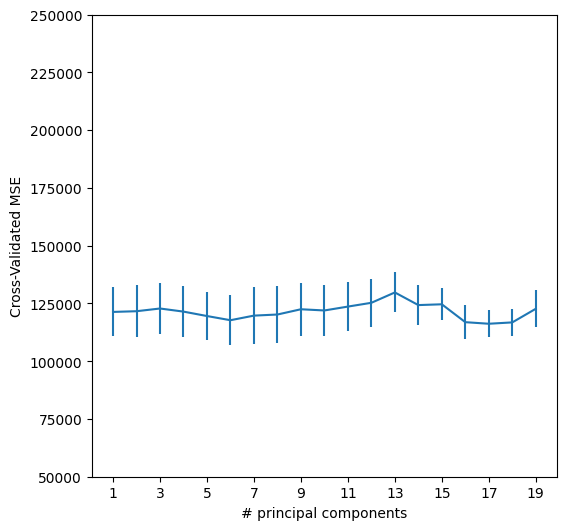

In [ ]:
#tuned_ridge = pipeCV.named_steps['ridge']
pcr_fig, ax = subplots(figsize = (6, 6))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
             grid.cv_results_['std_test_score']/np.sqrt(K))
ax.set_ylim([50000, 250000])
ax.set_xlabel('# principal components', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)
ax.set_xticks(n_comp[::2]);

We see that the smallest cross-validation error occurs when 17 components are used. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. **This suggests that a model that uses just a small number of components might suffice**.

The CV score is provided for each possible number of components from 1 to 19 inclusive. The `PCA()` method complains if we try to fit an intercept only with `n_components = 0` so we compute the MSE for just the null model with these splits.


In [ ]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv = kfold,
                             scoring = 'neg_mean_squared_error')
print(f"{-cv_null['test_score'].mean():.4f}")

204139.3069


The `explained_variance_ratio_` attribute of our `PCA` object provides the *percentage of variance explained* in the predictors and in the response using different number of components. This concept is discussed in greater detail in Section 12.2.  

In [ ]:
print(pipe.named_steps['pca'].explained_variance_ratio_)

[0.3831424  0.21841076]


**Briefly, we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components**. For example, setting $M = 1$ only captures $38.31$% of all the variance, or information, in the predictors, while using $M = 2$ captures an additional $21.84$%, for a total of $60.15$% of the variance. By $M = 6$ it increases to $88.63$%. If we were to use all $M = p = 19$ components, this would increase to $100%$.

#####***Partial Least Squares (PLS)***

Partial least squares (PLS) is implemented in the `PLSRegression()` function.

In [ ]:
pls = PLSRegression(n_components = 2,
                    scale = True)
pls.fit(X, Y)

PLSRegression()

As was the case in PCR, we will want to use CV to choose the number of components.

In [ ]:
param_grid = {'n_components': range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

As for aour other methods, we plot the MSE.

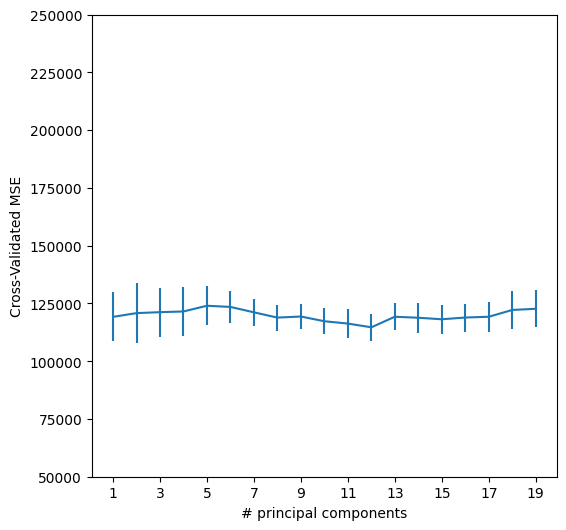

In [ ]:
pls_fig, ax = subplots(figsize = (6, 6))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
             grid.cv_results_['std_test_score']/np.sqrt(K))
ax.set_xlabel('# principal components', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000, 250000]);

CV error is minimized at 12, though there is little noticable difference between this point and a much lower number like 2 or 3 components.

###**6.6 Exercises**
---

#####***Applied***


1. In this exercise, we will generate simulated data, and wil then use this data to perform forward and bacward stepwise selection.

  (a) Create a random number generator and use its `normal()` method to generate a predictor $X$ of length $n = 100$ as well as a noise vector $\epsilon$ of length $n = 100$.

In [ ]:
def normal_generator(n, mean, std):
  np.random.seed(42)
  return np.random.normal(loc = mean, scale= std, size = n)
X = normal_generator(100, 0, 1)
epsilon = normal_generator(100, 0, 0.5)

In [ ]:
print(f"X = {X[:5]}")
print("-"*60)
print(f"Epsilon = {epsilon[:5]}")

X = [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
------------------------------------------------------------
Epsilon = [ 0.24835708 -0.06913215  0.32384427  0.76151493 -0.11707669]


(b) Generate a response vector $Y$ of length $n = 100$ according to the model

$$Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$$

where $\beta_0, \beta_1, \beta_2$, and $\beta_3$ are constants of your choice.

In [ ]:
def generate_response(beta_vector, X):
  """
   Parameters:
    X : array-like, predictor variable
    beta_vector : list or array of coefficients [β₀, β₁, β₂, β₃]

    Returns:
    y: response vector
  """
  # Generate noise
  epsilon = normal_generator(len(X), 0, 0.5)
  # Initialize y with the intercept (β₀)
  y = beta_vector[0]*np.ones_like(X)
  # Add polynomial terms
  for i, beta in enumerate(beta_vector[1:], start = 1):
    y += beta*X**i

  # Add noise
  y += epsilon

  return y

In [ ]:
betas = [np.pi, np.sqrt(2), np.sqrt(3), (1 + np.sqrt(5))/2]
X = normal_generator(100, 0, 1)
y = generate_response(betas, X)

(c) Use forward stepwise selection in order to select a model containing the predictors $X, X^2, ..., X^{10}$. What is the model obtained according to $C_p$? Report the coefficients of the model obtained.

First, we need to add the new columns $X^2, X^3, ..., X^{10}$.

In [ ]:
df = pd.DataFrame({"X": X,
                   "y": y})

In [ ]:
# Add the correspondant vector values within the dataframe
degree_poly = 10
for i in range(2, degree_poly + 1):
  vector = []
  for n in df['X']:
    vector.append(n**i)
  df[f"X{i}"] = vector

print(df.head())


          X          y        X2        X3        X4        X5         X6  \
0  0.496714   4.718043  0.246725  0.122552  0.060873  0.030237   0.015019   
1 -0.138264   2.905760  0.019117 -0.002643  0.000365 -0.000051   0.000007   
2  0.647689   5.547632  0.419500  0.271706  0.175981  0.113981   0.073824   
3  1.523030  15.790969  2.319620  3.532850  5.380637  8.194870  12.481032   
4 -0.234153   2.767565  0.054828 -0.012838  0.003006 -0.000704   0.000165   

             X7            X8            X9           X10  
0  7.460119e-03  3.705547e-03  1.840597e-03  9.142508e-04  
1 -9.659851e-07  1.335613e-07 -1.846675e-08  2.553293e-09  
2  4.781493e-02  3.096918e-02  2.005838e-02  1.299158e-02  
3  1.900898e+01  2.895125e+01  4.409362e+01  6.715590e+01  
4 -3.859250e-05  9.036565e-06 -2.115942e-06  4.954550e-07  


In [ ]:
design = MS(df.columns.drop('y')).fit(df)
y = np.array(df['y'])
X = design.transform(df)
sigma_2 = OLS(y, X).fit().scale
print(sigma_2)

5.867081204687024e-26


In [ ]:
neg_Cp = partial(nCp, sigma_2)

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = len(design.terms))

In [ ]:
df_Cp = sklearn_selected(OLS,
                         strategy,
                         scoring = neg_Cp)
df_Cp.fit(df, y)
df_Cp.selected_state_

('X', 'X2', 'X3')

(d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

In [ ]:
strategy_bw = Stepwise.first_peak(design,
                                  direction = 'backwards',
                                  max_terms = len(design.terms))
df_Cp_bw = sklearn_selected(OLS,
                            strategy_bw,
                            scoring = neg_Cp)
df_Cp_bw.fit(df, y)
df_Cp_bw.selected_state_

('X', 'X2', 'X3')

(e) Now fit a lasso model to the simulated data, again using $X, X^2, ..., X^{10}$ as predictors. Use cross-validation to select the optimal $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

In [ ]:
scaler = StandardScaler(with_mean = True, with_std = True)
lassoCV = skl.ElasticNetCV(n_alphas = 100,
                           l1_ratio = 1,
                           cv = kfold)
pipeCV = Pipeline(steps = [('scaler', scaler),
                           ('lasso', lassoCV)])
pipeCV.fit(X, y)
tunned_lasso = pipeCV.named_steps['lasso']
print(f"Lasso Lambda: {tunned_lasso.alpha_:.4f}")


Lasso Lambda: 0.0047


In [ ]:
# Original line: Xs = X - X.mean(0)[None,:]
# Fix: Prepare the predictor matrix for Lasso

# The current X (capital X) is a DataFrame from design.transform(df) including an 'intercept' column.
# For skl.lasso_path, we typically provide the predictor matrix without the intercept column.

# 1. Create a new predictor DataFrame by dropping the 'intercept' column
X_pred_df = X.drop('intercept', axis=1)

# 2. Store the column names for later use in soln_path DataFrame
poly_feature_names = X_pred_df.columns

# 3. Convert the predictor DataFrame to a NumPy array for standardization
X_pred_array = X_pred_df.values

# 4. Standardize the predictor array using StandardScaler
# Re-instantiate a local scaler to ensure it's fresh for this step.
scaler_local = StandardScaler(with_mean=True, with_std=True)
Xs = scaler_local.fit_transform(X_pred_array)

# Xs is now a properly standardized NumPy array of polynomial features (without intercept).

In [ ]:
Xs = X_pred_array - X_pred_array.mean(axis=0)[None,:]
lambdas, soln_array = skl.lasso_path(Xs,
                                     y, # Use the simulated response 'y' (lowercase)
                                     n_alphas = 100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns = poly_feature_names, # Use the correct column names for the simulated polynomial features
                         index = -np.log(lambdas))
print(soln_path)

             X   X2   X3   X4   X5   X6        X7        X8        X9  \
-8.194389  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.000000 -0.000000  0.000000   
-8.124614  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.000000 -0.000000  0.000000   
-8.054839  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.000000 -0.000000  0.000000   
-7.985063  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.000000 -0.000000  0.000000   
-7.915288  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.000000 -0.000000  0.000000   
...        ...  ...  ...  ...  ...  ...       ...       ...       ...   
-1.565735  0.0  0.0  0.0  0.0  0.0  0.0  0.137569  0.014727  0.024427   
-1.495960  0.0  0.0  0.0  0.0  0.0  0.0  0.161833  0.023820  0.017374   
-1.426185  0.0  0.0  0.0  0.0  0.0  0.0  0.189797  0.034119  0.009142   
-1.356409  0.0  0.0  0.0  0.0  0.0  0.0  0.220484  0.045296  0.000037   
-1.286634  0.0  0.0  0.0  0.0  0.0  0.0  0.222753  0.046467 -0.000000   

                X10  
-8.194389 -0.000000  
-8.124614 -0.000106  
-8.054839 -0.000205  
-7.985063 -0.000297  
-7.915288 -0.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.194593182142853, tolerance: 0.4065278043991376
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2093264214772717, tolerance: 0.4065278043991376
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0995492165138785, tolerance: 0.4065278043991376
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergen

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-877637095.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


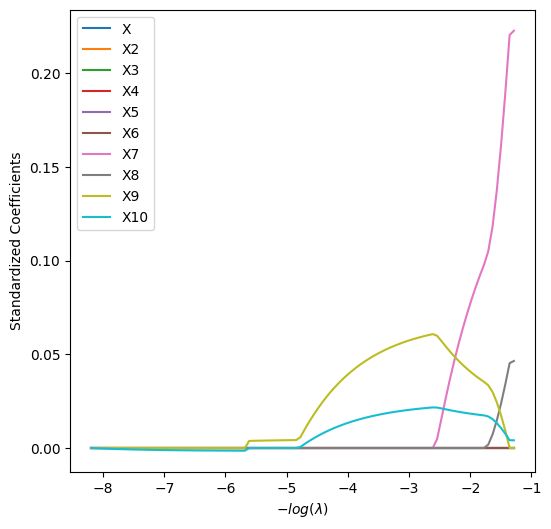

In [ ]:
path_fig, ax = subplots(figsize = (6, 6))
soln_path.plot(ax = ax, legend = False)
ax.legend(loc = 'upper left')
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Standardized Coefficients', fontsize = 10);

In [ ]:
print(f"{np.min(tunned_lasso.mse_path_.mean(1)):.4f}")

0.0002


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1599592861.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


Text(0, 0.5, 'Cross-Validated MSE')

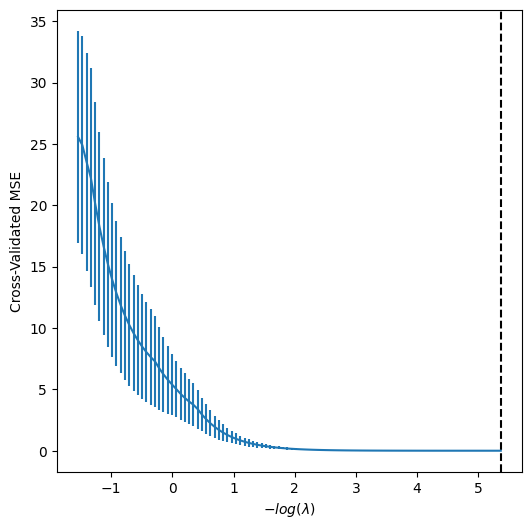

In [ ]:
lassoCV_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(tunned_lasso.alphas_),
            tunned_lasso.mse_path_.mean(1),
            yerr = tunned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(tunned_lasso.alpha_), c = 'k', ls = '--')
#ax.set_ylim([50000, 250000])
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)

In [ ]:
#print(tunned_lasso.coef_)
for i, beta in enumerate(tunned_lasso.coef_):
  print(f"Beta_{i} = {beta:.4f}")

Beta_0 = 0.0000
Beta_1 = 1.7330
Beta_2 = 1.9777
Beta_3 = 4.3278
Beta_4 = 0.0000
Beta_5 = 0.0000
Beta_6 = -0.0000
Beta_7 = 0.0000
Beta_8 = -0.0000
Beta_9 = 0.0000
Beta_10 = -0.0000


(f) Now generate a response vector $Y$ according to the model

$$Y = \beta_0 + \beta_7X^7 + \epsilon,$$

and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [ ]:
betas = [np.pi, 0, 0, 0, 0, 0, 0, -np.sqrt(5)]
y_f = generate_response(betas, df["X"])
print(y_f.head())

0     3.373268
1     3.072463
2     3.358519
3   -38.602274
4     3.024602
Name: X, dtype: float64


In [ ]:
df['y_f'] = y_f
print(df.head())

          X          y        X2        X3        X4        X5         X6  \
0  0.496714   4.718043  0.246725  0.122552  0.060873  0.030237   0.015019   
1 -0.138264   2.905760  0.019117 -0.002643  0.000365 -0.000051   0.000007   
2  0.647689   5.547632  0.419500  0.271706  0.175981  0.113981   0.073824   
3  1.523030  15.790969  2.319620  3.532850  5.380637  8.194870  12.481032   
4 -0.234153   2.767565  0.054828 -0.012838  0.003006 -0.000704   0.000165   

             X7            X8            X9           X10        y_f  
0  7.460119e-03  3.705547e-03  1.840597e-03  9.142508e-04   3.373268  
1 -9.659851e-07  1.335613e-07 -1.846675e-08  2.553293e-09   3.072463  
2  4.781493e-02  3.096918e-02  2.005838e-02  1.299158e-02   3.358519  
3  1.900898e+01  2.895125e+01  4.409362e+01  6.715590e+01 -38.602274  
4 -3.859250e-05  9.036565e-06 -2.115942e-06  4.954550e-07   3.024602  


***Forward Stepwise Selection***

In [ ]:
design_f = MS(df.columns.drop(['y', 'y_f'])).fit(df)
y = np.array(df['y_f'])
X = design.transform(df)
sigma_2_f = OLS(y, X).fit().scale
print(sigma_2_f)

1.8288746379368418e-24


In [ ]:
neg_Cp = partial(nCp, sigma_2_f)

In [ ]:
strategy_f = Stepwise.first_peak(design_f,
                               direction = 'forward',
                               max_terms = len(design.terms))

In [ ]:
df_Cp_f = sklearn_selected(OLS,
                         strategy_f,
                         scoring = neg_Cp)
df_Cp_f.fit(df, y)
df_Cp_f.selected_state_

('X', 'X7')

***Lasso Regression***

In [ ]:
scaler = StandardScaler(with_mean = True, with_std = True)
lassoCV = skl.ElasticNetCV(n_alphas = 100,
                           l1_ratio = 1,
                           cv = kfold)
pipeCV = Pipeline(steps = [('scaler', scaler),
                           ('lasso', lassoCV)])
pipeCV.fit(X, y)
tunned_lasso = pipeCV.named_steps['lasso']
print(f"Lasso Lambda: {tunned_lasso.alpha_:.4f}")

Lasso Lambda: 0.1940


In [ ]:
# 1. Create a new predictor DataFrame by dropping the 'intercept' column
X_pred_df = X.drop('intercept', axis=1)

# 2. Store the column names for later use in soln_path DataFrame
poly_feature_names = X_pred_df.columns

# 3. Convert the predictor DataFrame to a NumPy array for standardization
X_pred_array = X_pred_df.values

# 4. Standardize the predictor array using StandardScaler
# Re-instantiate a local scaler to ensure it's fresh for this step.
scaler_local = StandardScaler(with_mean=True, with_std=True)
Xs = scaler_local.fit_transform(X_pred_array)

In [ ]:
Xs = X_pred_array - X_pred_array.mean(axis=0)[None,:]
lambdas, soln_array = skl.lasso_path(Xs,
                                     y, # Use the simulated response 'y' (lowercase)
                                     n_alphas = 100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns = poly_feature_names, # Use the correct column names for the simulated polynomial features
                         index = -np.log(lambdas))
print(soln_path)

              X   X2   X3   X4   X5   X6   X7   X8        X9       X10
-12.573885 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.000000  0.000000
-12.504109 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.000000  0.008446
-12.434334 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.000000  0.016322
-12.364559 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.000000  0.023667
-12.294783 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.000000  0.030518
...         ...  ...  ...  ...  ...  ...  ...  ...       ...       ...
-5.945230  -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.466781 -0.052969
-5.875455  -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.480133 -0.058084
-5.805680  -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.492534 -0.062835
-5.735905  -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.504155 -0.067288
-5.666129  -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.0  0.0 -0.514946 -0.071422

[100 rows x 10 columns]


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-877637095.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


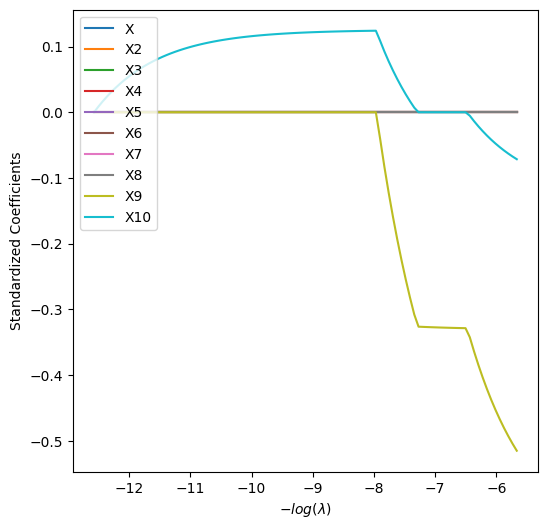

In [ ]:
path_fig, ax = subplots(figsize = (6, 6))
soln_path.plot(ax = ax, legend = False)
ax.legend(loc = 'upper left')
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Standardized Coefficients', fontsize = 10);

In [ ]:
print(f"{np.min(tunned_lasso.mse_path_.mean(1)):.4f}")

990.9762


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1599592861.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


Text(0, 0.5, 'Cross-Validated MSE')

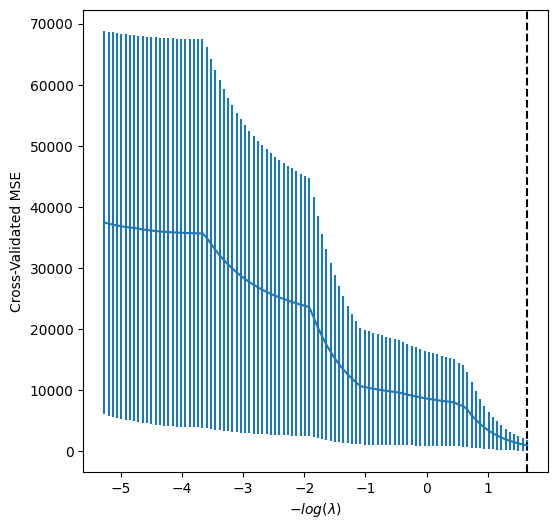

In [ ]:
lassoCV_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(tunned_lasso.alphas_),
            tunned_lasso.mse_path_.mean(1),
            yerr = tunned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(tunned_lasso.alpha_), c = 'k', ls = '--')
#ax.set_ylim([50000, 250000])
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)

In [ ]:
for i, beta in enumerate(tunned_lasso.coef_):
  print(f"Beta_{i} = {beta:.4f}")

Beta_0 = 0.0000
Beta_1 = 1.1155
Beta_2 = 0.0000
Beta_3 = -0.0000
Beta_4 = 0.0000
Beta_5 = -26.3041
Beta_6 = 1.7554
Beta_7 = -121.7502
Beta_8 = 0.0000
Beta_9 = -45.5193
Beta_10 = 0.0000


9. In this exercise, we will predict the number of applications received using the other variables in the `College` data set.


(a) Split the data set into training set and a test set.

In [ ]:
# Load the College data set
College = load_data('College')
print(College.head())

  Private  Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0     Yes  1660    1232     721         23         52         2885   
1     Yes  2186    1924     512         16         29         2683   
2     Yes  1428    1097     336         22         50         1036   
3     Yes   417     349     137         60         89          510   
4     Yes   193     146      55         16         44          249   

   P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
0          537      7440        3300    450      2200   70        78   
1         1227     12280        6450    750      1500   29        30   
2           99     11250        3750    400      1165   53        66   
3           63     12960        5450    450       875   92        97   
4          869      7560        4120    800      1500   76        72   

   S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0       18.1           12    7041         60  
1       12.2           16   10527         56  
2    

In [ ]:
X_col, y_col = College.drop('Apps', axis = 1), College['Apps']
print(X_col.head())
print('-'*50)
print(y_col.head())

  Private  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
0     Yes    1232     721         23         52         2885          537   
1     Yes    1924     512         16         29         2683         1227   
2     Yes    1097     336         22         50         1036           99   
3     Yes     349     137         60         89          510           63   
4     Yes     146      55         16         44          249          869   

   Outstate  Room.Board  Books  Personal  PhD  Terminal  S.F.Ratio  \
0      7440        3300    450      2200   70        78       18.1   
1     12280        6450    750      1500   29        30       12.2   
2     11250        3750    400      1165   53        66       12.9   
3     12960        5450    450       875   92        97        7.7   
4      7560        4120    800      1500   76        72       11.9   

   perc.alumni  Expend  Grad.Rate  
0           12    7041         60  
1           16   10527         56  
2       

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_col, y_col,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (520, 17)
X_test shape: (257, 17)
y_train shape: (520,)
y_test shape: (257,)


(b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [ ]:
design = MS(X_train).fit(X_train)
Y_train_col = np.array(y_train)
X_train_col = design.transform(X_train)
linear_model_col = OLS(Y_train_col, X_train_col).fit()
print(linear_model_col.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     545.5
Date:                Fri, 26 Dec 2025   Prob (F-statistic):          1.23e-310
Time:                        16:22:37   Log-Likelihood:                -4279.5
No. Observations:                 520   AIC:                             8595.
Df Residuals:                     502   BIC:                             8672.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     -670.2325    453.274     -1.479   

We now compute the associated MSE from the *least squares linear model*

In [ ]:
X_test_col = design.transform(X_test)
y_pred = linear_model_col.predict(X_test_col)
MSE_lm = ((y_pred - y_test)**2).mean()
print(f"MSE linear model: {MSE_lm:.2e}")

MSE linear model: 1.78e+06


(c) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

***Ridge Regression***

In [ ]:
# Extract features (excluding intercept) for standardization
X_features_train = X_train_col.drop('intercept', axis=1)

# Manually standardize these features
Xs_train_mean = X_features_train.mean(0)
Xs_train_std = X_features_train.std(0)

Xs_train_scaled = (X_features_train - Xs_train_mean)/Xs_train_std

# Calculate lambdas using the standard deviation of Y_train_col
lambdas = 10**np.linspace(8, -2, 100)/Y_train_col.std()

# Fit the ElasticNet.path with scaled features and correct lambdas
soln_array = skl.ElasticNet.path(Xs_train_scaled.values, Y_train_col,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
print(soln_array.shape)

(17, 100)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6546902578.960225, tolerance: 1309487.9035
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not c

In [ ]:
D = design.fit_transform(College)
D = D.drop('intercept', axis = 1)

In [ ]:
soln_path = pd.DataFrame(soln_array.T,
                         columns = D.columns,
                         index = -np.log(lambdas))
soln_path.index_name = "negative log(lambda)"
print(soln_path.sample(5))

            Private[Yes]       Accept       Enroll   Top10perc  Top25perc  \
 9.179280    -248.457231  4518.302936 -1132.263281  564.903706 -68.622262   
 11.039955   -248.616821  4521.925666 -1136.788392  565.567737 -69.087760   
 5.690515    -242.656013  4388.781368  -976.062321  541.287539 -52.171115   
 11.737708   -248.631602  4522.261399 -1137.208196  565.629284 -69.130913   
-8.729715      -0.262590     0.620440     0.547733    0.178226   0.213273   

            F.Undergrad  P.Undergrad    Outstate  Room.Board      Books  \
 9.179280    156.849180    26.094877 -324.608949  168.676333  24.341566   
 11.039955   157.871202    26.186378 -324.856292  168.442384  24.326017   
 5.690515    126.112954    22.500511 -315.441683  176.936223  24.963599   
 11.737708   157.966381    26.194831 -324.879189  168.420695  24.324581   
-8.729715      0.524769     0.255734    0.031283    0.112042   0.089041   

             Personal         PhD   Terminal  S.F.Ratio  perc.alumni  \
 9.179280   50

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2852988967.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


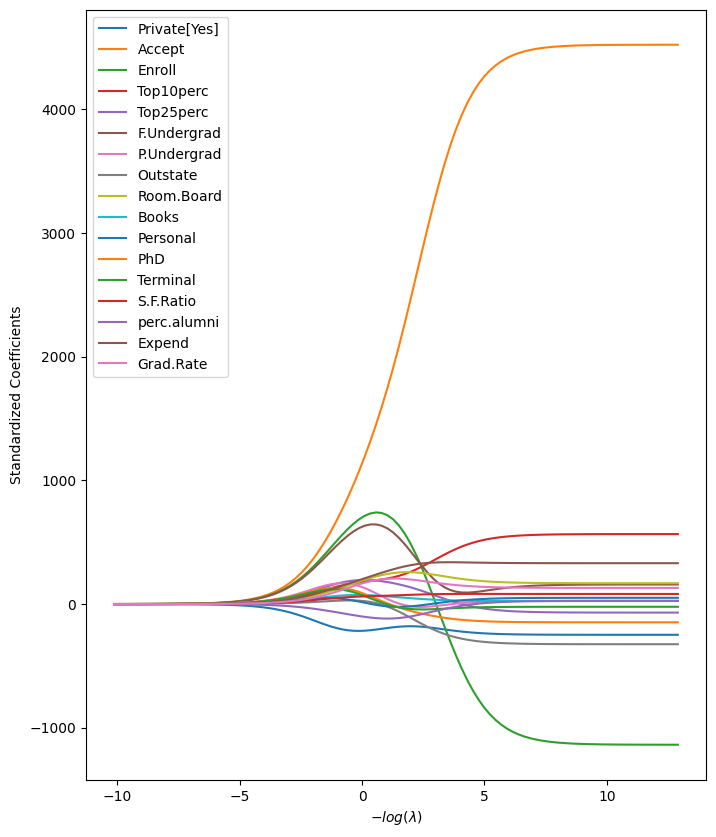

In [ ]:
path_fig, ax = subplots(figsize = (8, 10))
soln_path.plot(ax = ax, legend = False)
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Standardized Coefficients', fontsize = 10)
ax.legend(loc = 'upper left');

***Ridge Regression with $\lambda$ tunning using cross-validation***

In [ ]:
X_tr_col = X_train_col.drop('intercept', axis = 1)
X_train_col = np.asarray(X_tr_col)

In [ ]:
K = 5
kfold = skm.KFold(K, random_state = 0, shuffle = True)
lambdas = 10**np.linspace(8, -2, 100)/Y_train_col.std()
scaler = StandardScaler(with_mean = True, with_std = True)

ridgeCV = skl.ElasticNetCV(alphas = lambdas,
                           l1_ratio = 0,
                           cv = kfold)
pipeCV = Pipeline(steps= [('scaler', scaler),
                          ('ridge', ridgeCV)])

In [ ]:
pipeCV.fit(X_train_col, Y_train_col)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2442194165.0531735, tolerance: 488500.36951899045
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective di

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.49647818e+04, 1.97841626e+04, 1.56786106e+04, 1.24250307e+04,
       9.84662437e+03, 7.80328142e+03, 6.18396708e+03, 4.90068815e+03,
       3.88371155e+03, 3.07777499e+03, 2.43908404e+03, 1.93293239e+03,
       1.53181586e+03, 1.21393787e+03, 9.62025005e+02, 7.62388365e+02,
       6.04179741e+02, 4.78802112e+02,...
       2.07262004e-04, 1.64251594e-04, 1.30166579e-04, 1.03154788e-04,
       8.17484054e-05, 6.47842132e-05, 5.13403811e-05, 4.06863740e-05,
       3.22432556e-05, 2.55522286e-05, 2.02497042e-05, 1.60475443e-05,
       1.27174044e-05, 1.00783255e-05, 7.98690060e-06, 6.32948214e-06,
       5.01600635e-06, 3.97509925e-06, 3.15019818e-06, 2.49647818e-06]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

In [ ]:
design = MS(College.columns.drop('Apps')).fit(College)
Y_col = np.array(College['Apps'])
X_col = design.transform(College)

outer_valid = skm.ShuffleSplit(n_splits = 1,
                               test_size = 0.25,
                               random_state = 1)
inner_cv = skm.KFold(n_splits = 5,
                     shuffle = True,
                     random_state = 2)
ridgeCV = skl.ElasticNetCV(alphas = lambdas,
                           l1_ratio = 0,
                           cv = inner_cv)
pipeCV = Pipeline(steps = [('scaler', scaler),
                           ('ridge', ridgeCV)])

results_col = skm.cross_validate(pipeCV,
                             X_col,
                             y_col,
                             cv = outer_valid,
                             scoring = 'neg_mean_squared_error')

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2932046121.3153934, tolerance: 586490.6862546238
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did

In [ ]:
MSE_Ridge =  -results_col['test_score']
print(f"MSE Ridge Regression: {MSE_Ridge[0]:.2e}");

MSE Ridge Regression: 6.36e+05


(d) Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.

***Lasso Model***

In [ ]:
scaler = StandardScaler(with_mean = True, with_std = True)
lassoCV = skl.ElasticNetCV(n_alphas = 100,
                           l1_ratio = 1,
                           cv = kfold)
pipeCV = Pipeline(steps = [('scaler', scaler),
                           ('lasso', lassoCV)])
pipeCV.fit(X_col, y_col)
tunned_lasso = pipeCV.named_steps['lasso']
print(f"Lasso Lambda: {tunned_lasso.alpha_:.4f}")

Lasso Lambda: 25.7429


In [ ]:
# 1. Create a new predictor DataFrame by dropping the 'intercept' column
X_pred_df = X_col.drop('intercept', axis=1)

# 2. Store the column names for later use in soln_path DataFrame
poly_feature_names = X_pred_df.columns

# 3. Convert the predictor DataFrame to a NumPy array for standardization
X_pred_array = X_pred_df.values

# 4. Standardize the predictor array using StandardScaler
# Re-instantiate a local scaler to ensure it's fresh for this step.
scaler_local = StandardScaler(with_mean=True, with_std=True)
Xs = scaler_local.fit_transform(X_pred_array)
# Xs is now a properly standardized NumPy array of polynomial features (without intercept).

Xs = X_pred_array - X_pred_array.mean(axis=0)[None,:]
lambdas, soln_array = skl.lasso_path(Xs,
                                     y_col,
                                     n_alphas = 100)[:2]
soln_path_col = pd.DataFrame(soln_array.T,
                         columns = poly_feature_names, # Use the correct column names for the simulated polynomial features
                         index = -np.log(lambdas))
#print(soln_path_col)

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3152576307.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


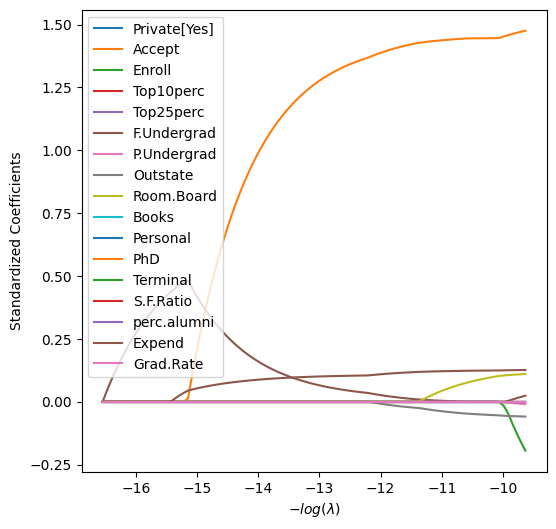

In [ ]:
path_fig, ax = subplots(figsize = (6, 6))
soln_path_col.plot(ax = ax, legend = False)
ax.legend(loc = 'upper left')
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Standardized Coefficients', fontsize = 10);

In [ ]:
MSE_lasso = np.min(tunned_lasso.mse_path_.mean(1))
print(f"MSE Lasso Model: {MSE_lasso:.4e}")

MSE Lasso Model: 1.3065e+06


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-665713742.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-log(\lambda)$', fontsize = 10)


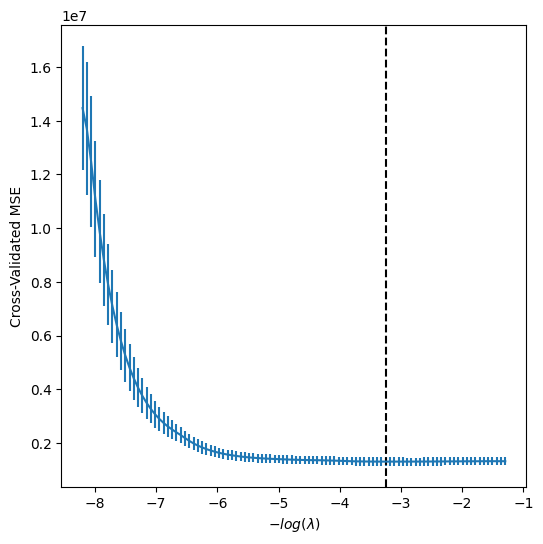

In [ ]:
lassoCV_fig, ax = subplots(figsize = (6, 6))
ax.errorbar(-np.log(tunned_lasso.alphas_),
            tunned_lasso.mse_path_.mean(1),
            yerr = tunned_lasso.mse_path_.std(1)/np.sqrt(K))
ax.axvline(-np.log(tunned_lasso.alpha_), c = 'k', ls = '--')
#ax.set_ylim([50000, 250000])
ax.set_xlabel('$-log(\lambda)$', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10);


In [ ]:
#print(tunned_lasso.coef_)
for i, beta in enumerate(tunned_lasso.coef_):
  print(f"Beta_{i} = {beta:.4f}")

Beta_0 = 0.0000
Beta_1 = -179.7535
Beta_2 = 3506.5835
Beta_3 = -115.0684
Beta_4 = 544.5442
Beta_5 = -9.9495
Beta_6 = -0.0000
Beta_7 = 19.8924
Beta_8 = -209.8104
Beta_9 = 130.3903
Beta_10 = 0.0000
Beta_11 = 0.0000
Beta_12 = -81.5732
Beta_13 = -49.0000
Beta_14 = 8.5940
Beta_15 = -12.9854
Beta_16 = 354.2309
Beta_17 = 78.2604


(e) Fit a PCR model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.

In [ ]:
pca = PCA(n_components = 17)
linreg = skl.LinearRegression()
scaler = StandardScaler(with_mean = True, with_std = True)
pipe_pca = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])

# The fit call here is redundant as GridSearchCV will fit the pipeline.
# pipe_pca.fit(X_col, Y_col)

param_grid_pca = {'pca__n_components': range(1, 17)}
K = 5
kfold = skm.KFold(K, random_state = 0, shuffle = True)
grid_pcr = skm.GridSearchCV(pipe_pca,
                        param_grid_pca,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
grid_pcr.fit(X_col.drop('intercept', axis = 1), Y_col)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=17)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

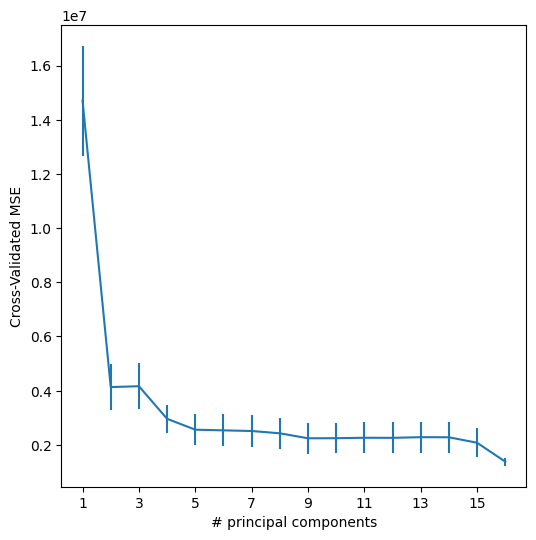

In [ ]:
pcr_fig, ax = subplots(figsize = (6, 6))
n_comp = param_grid_pca['pca__n_components']
ax.errorbar(n_comp,
            -grid_pcr.cv_results_['mean_test_score'],
             grid_pcr.cv_results_['std_test_score']/np.sqrt(K))
#ax.set_ylim([50000, 250000])
ax.set_xlabel('# principal components', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10)
ax.set_xticks(n_comp[::2]);

Based on the results above, we can observe that the PCA performs well when including five components--relied on CV-MSE. As additional components included within the PCR model moderately decrease the Mean Square Error (MSE. )

In [ ]:
pipe_pca.fit(X_col.drop('intercept', axis = 1), Y_col)
print(pipe_pca.named_steps['pca'].explained_variance_ratio_)

[0.31669858 0.25627714 0.06997454 0.05609877 0.05482508 0.04988611
 0.0361328  0.03414762 0.0309907  0.02401884 0.02104596 0.01803162
 0.0109114  0.00848544 0.00608774 0.00476065 0.00162701]


Test Error:

In [ ]:
pcr_pred = grid_pcr.predict(X_test_col.drop('intercept', axis = 1))

In [ ]:
pcr_MSE = ((y_test - pcr_pred)**2).mean()
print(f"Principal Components Regression MSE: {pcr_MSE:.4e}")

Principal Components Regression MSE: 1.4219e+06


(f) Fit a PLS model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.

In [ ]:
K = 5
pls = PLSRegression(n_components = 17,
                    scale = True)
kfold = skm.KFold(K, random_state = 0, shuffle = True)

param_grid_pls = {'n_components': range(1, 17)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
grid.fit(X_tr_col, Y_train_col)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(n_components=17),
             param_grid={'n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

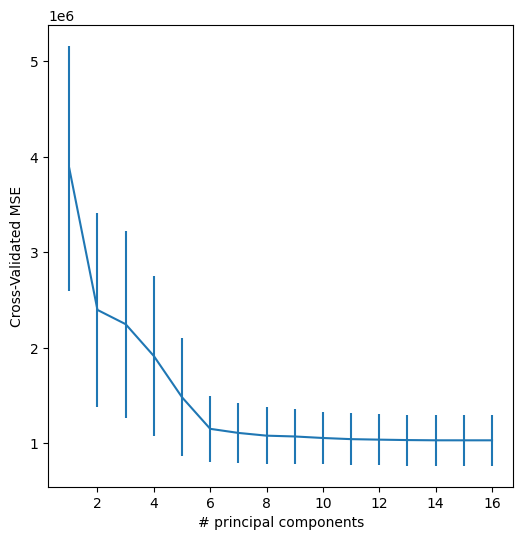

In [ ]:
pls_fig, ax = subplots(figsize = (6, 6))
n_comp_pls = param_grid_pls['n_components']
ax.errorbar(n_comp_pls,
            -grid.cv_results_['mean_test_score'],
             grid.cv_results_['std_test_score']/np.sqrt(K))
#ax.set_ylim([50000, 250000])
ax.set_xlabel('# principal components', fontsize = 10)
ax.set_ylabel('Cross-Validated MSE', fontsize = 10);
#ax.set_xticks(n_comp_pls[::2]);

In [ ]:
print(grid.best_estimator_)

PLSRegression(n_components=15)


In [ ]:
pls_pred = grid.predict(X_test_col.drop('intercept', axis = 1))

Test Error:

In [ ]:
pls_MSE = ((y_test - pls_pred)**2).mean()
print(f"Partial Least Squared Regression MSE: {pls_MSE:.4e}")

Partial Least Squared Regression MSE: 1.7756e+06


(g) Comment on the results obtained. How accurately can we predict the number of college aplications received? Is there mch difference among the test errors resulting from these five approacches?

In [ ]:
mse_dict = {
    "MSE Linear Model": MSE_lm,
    "MSE Ridge": MSE_Ridge[0],
    "MSE Lasso": MSE_lasso,
    "MSE PCR": pcr_MSE,
    "MSE PLS": pls_MSE
}

for name, mse in mse_dict.items():
    print(f"{name}: {mse:.4e}")

MSE Linear Model: 1.7756e+06
MSE Ridge: 6.3608e+05
MSE Lasso: 1.3065e+06
MSE PCR: 1.4219e+06
MSE PLS: 1.7756e+06


We can observe that the lowest MSE by cross-validation was obtained by the Ridge model (MSE Ridge = $6.36exp+05$).  

10. We have seen that as the number of features used in the model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

(a) Generate a data set with $p = 20$ features, $n = 1,000$ observations, and an associated quantitative response vector generated according to the model

$$Y = X\beta + \epsilon,$$

where $\beta$ has some elements that are exactly equal to zero.